In [28]:
import sys
sys.path.insert(0, "src")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid")
np.random.seed(42)

print("Библиотеки загружены.")


Библиотеки загружены.


In [29]:
train = pd.read_csv("data/train_c.csv")
test = pd.read_csv("data/test_c.csv")

print("train shape:", train.shape)
print("test shape:", test.shape)
train.head()


train shape: (11017, 35)
test shape: (5000, 35)


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0


In [30]:
print("train dtypes:")
print(train.dtypes.value_counts())
print("\nmissing in train:")
missing_train = train.isnull().sum()
print(missing_train[missing_train > 0].sort_values(ascending=False))

train dtypes:
float64    29
object      6
Name: count, dtype: int64

missing in train:
TotalAssets                   1031
CreditScore                   1031
LoanAmount                    1031
BaseInterestRate              1031
NetWorth                      1031
MonthlyDebtPayments           1031
CheckingAccountBalance        1031
LoanPurpose                   1031
BankruptcyHistory             1031
JobTenure                      530
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
ApplicationDate                530
EmploymentStatus               530
EducationLevel                 530
InterestRate                   530
MonthlyLoanPayment             530
TotalDebtToIncomeRatio         530
Experience                     530
PaymentHistory                 530
SavingsAccountBalance          530
LengthOfCreditHistory          530
Age                            530
PreviousLoanDefaults           530
DebtToIncomeRatio              530
Num

Target distribution:
LoanApproved
1.0    5367
0.0    5120
Name: count, dtype: int64

Class balance: LoanApproved
1.0    0.511776
0.0    0.488224
Name: proportion, dtype: float64


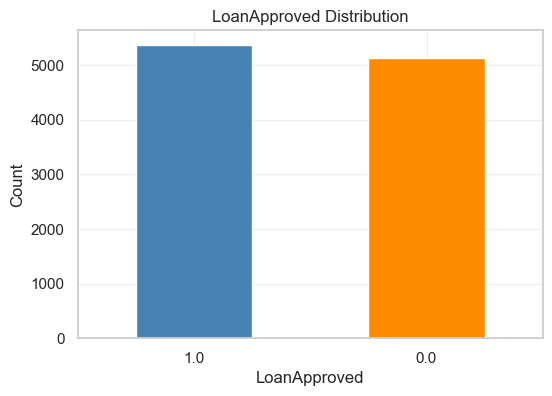

In [31]:
print("Target distribution:")
print(train['LoanApproved'].value_counts())
print(f"\nClass balance: {train['LoanApproved'].value_counts(normalize=True)}")

plt.figure(figsize=(6, 4))
train['LoanApproved'].value_counts().plot(kind='bar', color=['steelblue', 'darkorange'])
plt.title("LoanApproved Distribution")
plt.xlabel("LoanApproved")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()


In [32]:
# функция для анализа признаков
def analyze_features(df, target_col="LoanApproved", max_scatters=9, max_hists=9, max_corr_features=30):
    numeric_df = df.select_dtypes(include=[np.number]).copy()
    
    if target_col not in numeric_df.columns:
        print(f"Целевая колонка '{target_col}' не найдена.")
        return

    corr = numeric_df.corr()
    target_corr = corr[target_col].abs().sort_values(ascending=False)
    
    # 1. Correlation Matrices
    all_features = target_corr.index.tolist()
    if target_col in all_features:
        all_features.remove(target_col)
    
    features_to_show = all_features[:max_corr_features]
    chunk_size = 15
    feature_chunks = [features_to_show[i:i + chunk_size] for i in range(0, len(features_to_show), chunk_size)]
    
    print(f"\n--- Correlation Matrices (Top {len(features_to_show)} features split by 15) ---")
    
    for i, chunk in enumerate(feature_chunks):
        features_in_chunk = chunk + [target_col]
        corr_chunk = corr.loc[features_in_chunk, features_in_chunk]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_chunk, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.8})
        plt.title(f"Correlation Matrix - Group {i+1} (Features {i*chunk_size + 1}-{min((i+1)*chunk_size, len(features_to_show))})")
        plt.tight_layout()
        plt.show()

    # 2. Scatter plots
    scatter_features = target_corr.index[1:max_scatters+1]
    n_scatters = len(scatter_features)
    
    if n_scatters > 0:
        cols = 3
        rows = (n_scatters + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
        axes = axes.flatten()
        
        for i, feature in enumerate(scatter_features):
            sns.scatterplot(data=df, x=feature, y=target_col, ax=axes[i], alpha=0.4, s=15, color='steelblue')
            r = numeric_df[feature].corr(numeric_df[target_col])
            axes[i].set_title(f"{feature} vs {target_col}\n(corr = {r:+.3f})")
            axes[i].grid(True, alpha=0.3)
            
        for j in range(i + 1, len(axes)): 
            fig.delaxes(axes[j])
        plt.suptitle(f"Top {n_scatters} Scatter Plots", y=1.02, fontsize=16)
        plt.tight_layout()
        plt.show()

    # 3. Histograms
    skewness = numeric_df.apply(lambda x: x.skew()).abs().sort_values(ascending=False)
    hist_features = skewness.index[:max_hists]
    n_hists = len(hist_features)
    
    if n_hists > 0:
        cols = 3
        rows = (n_hists + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
        axes = axes.flatten()
        
        for i, feature in enumerate(hist_features):
            sns.histplot(data=df, x=feature, ax=axes[i], bins=40, kde=True, color='darkorange')
            skew_val = df[feature].skew()
            axes[i].set_title(f"{feature}\n(skew = {skew_val:+.2f})")
            axes[i].grid(True, alpha=0.3)
            
        for j in range(i + 1, len(axes)): 
            fig.delaxes(axes[j])
        plt.suptitle(f"Top {n_hists} Skewed Distributions", y=1.02, fontsize=16)
        plt.tight_layout()
        plt.show()



--- Correlation Matrices (Top 28 features split by 15) ---


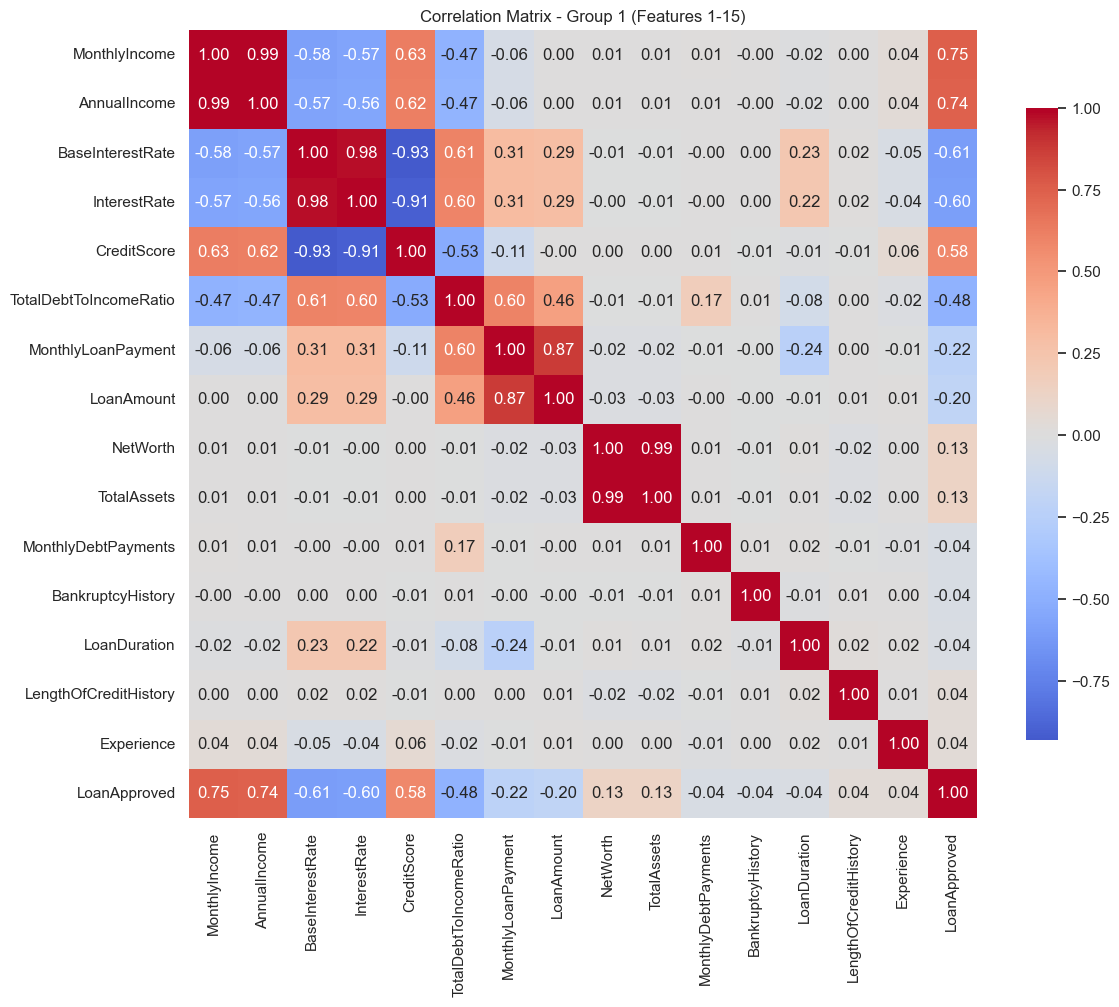

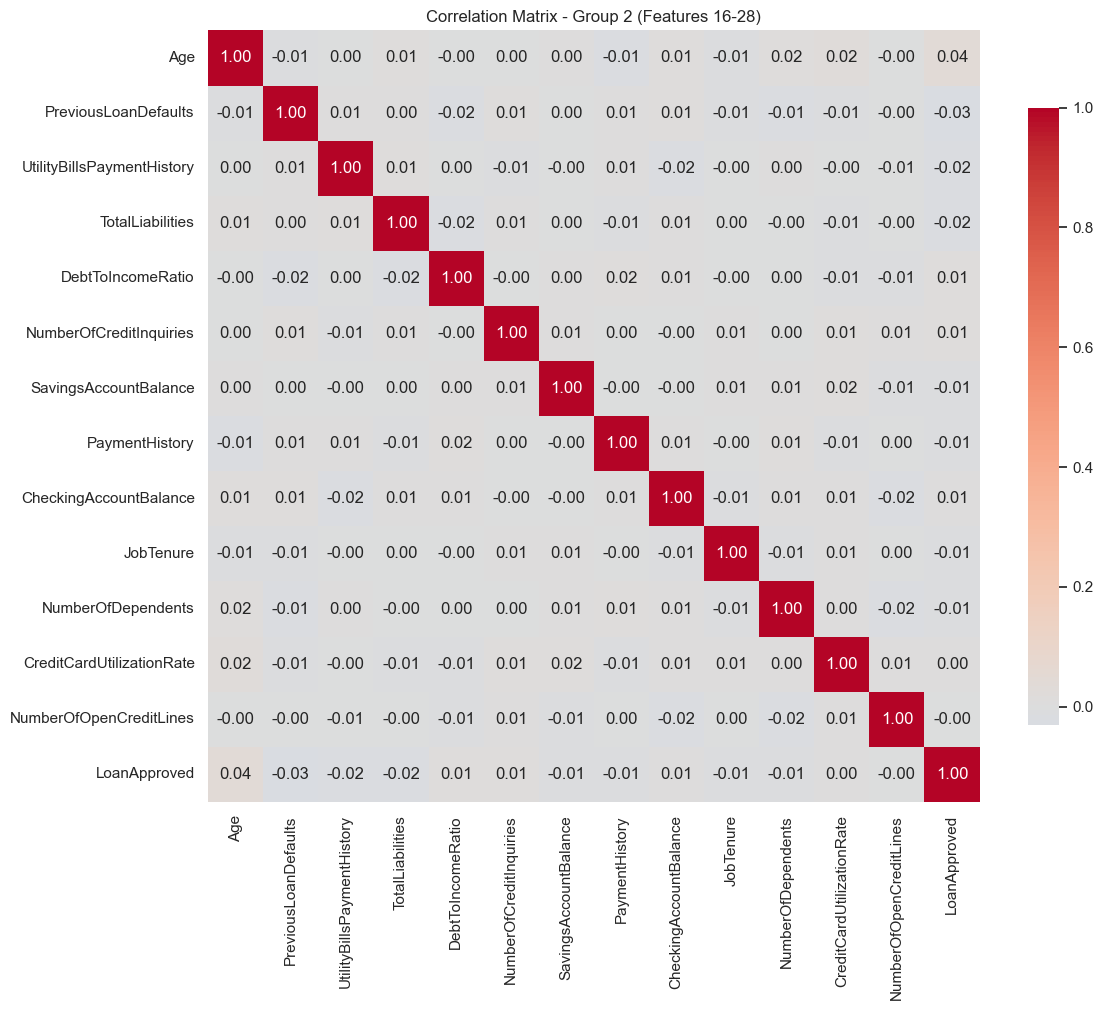

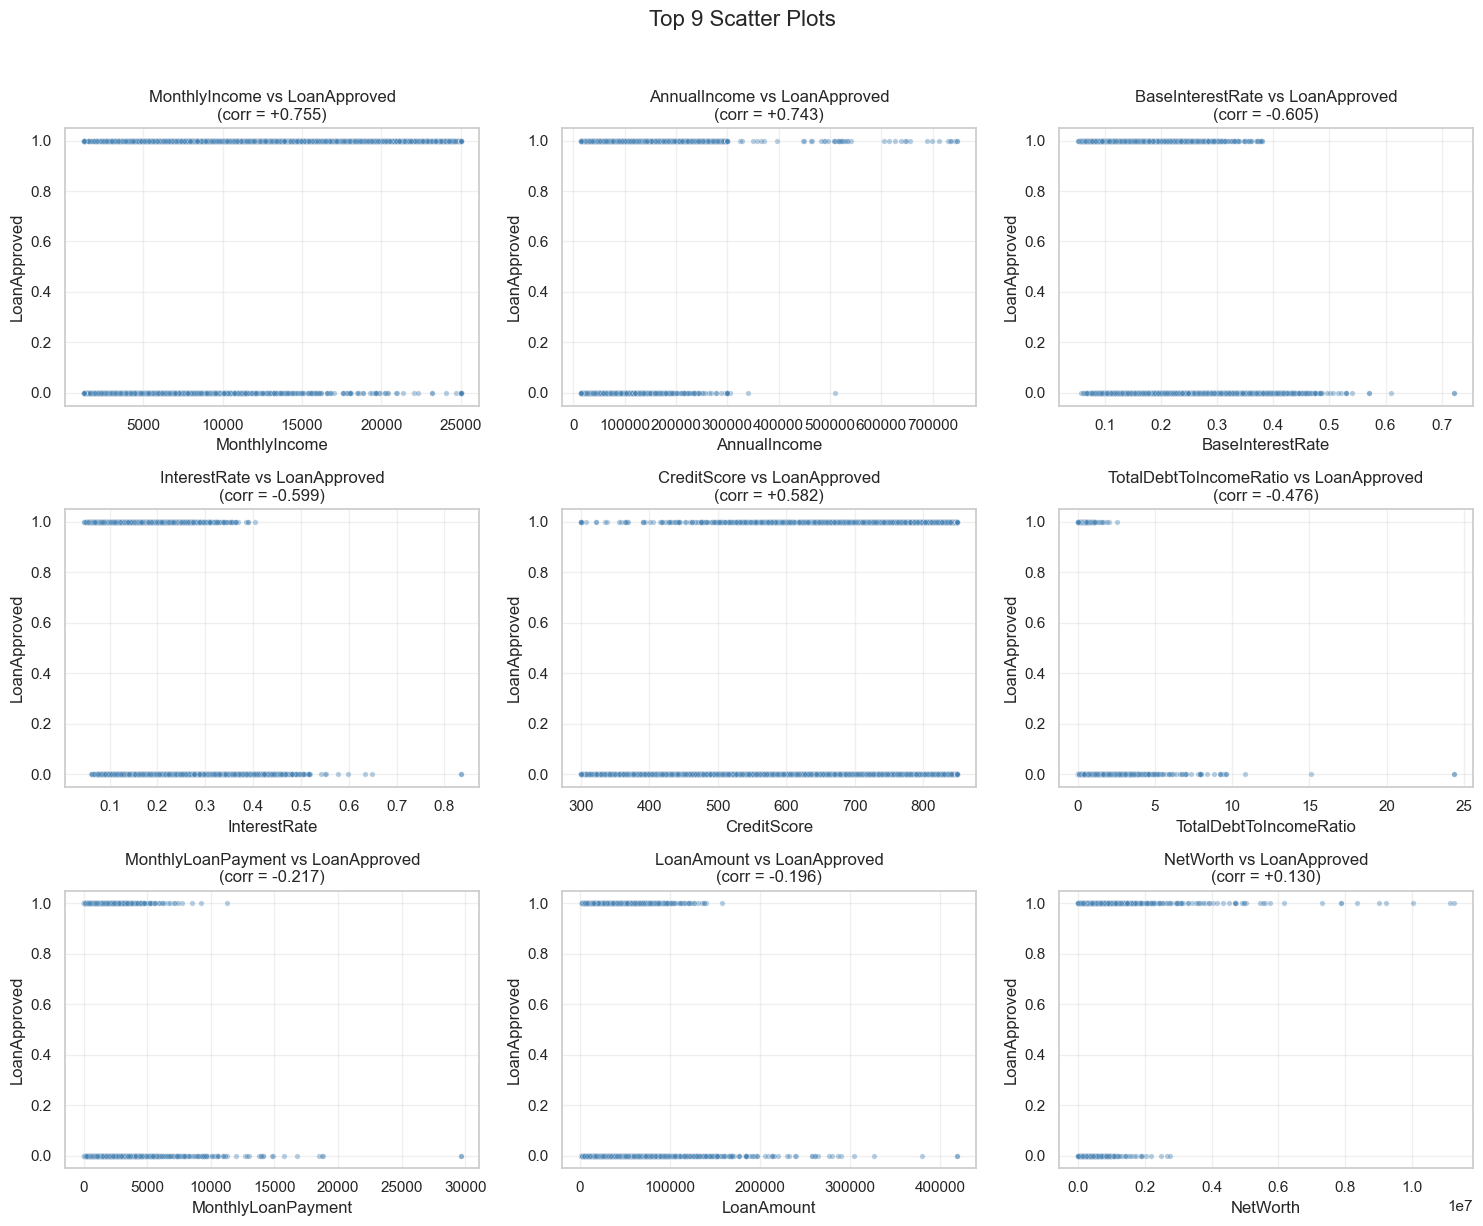

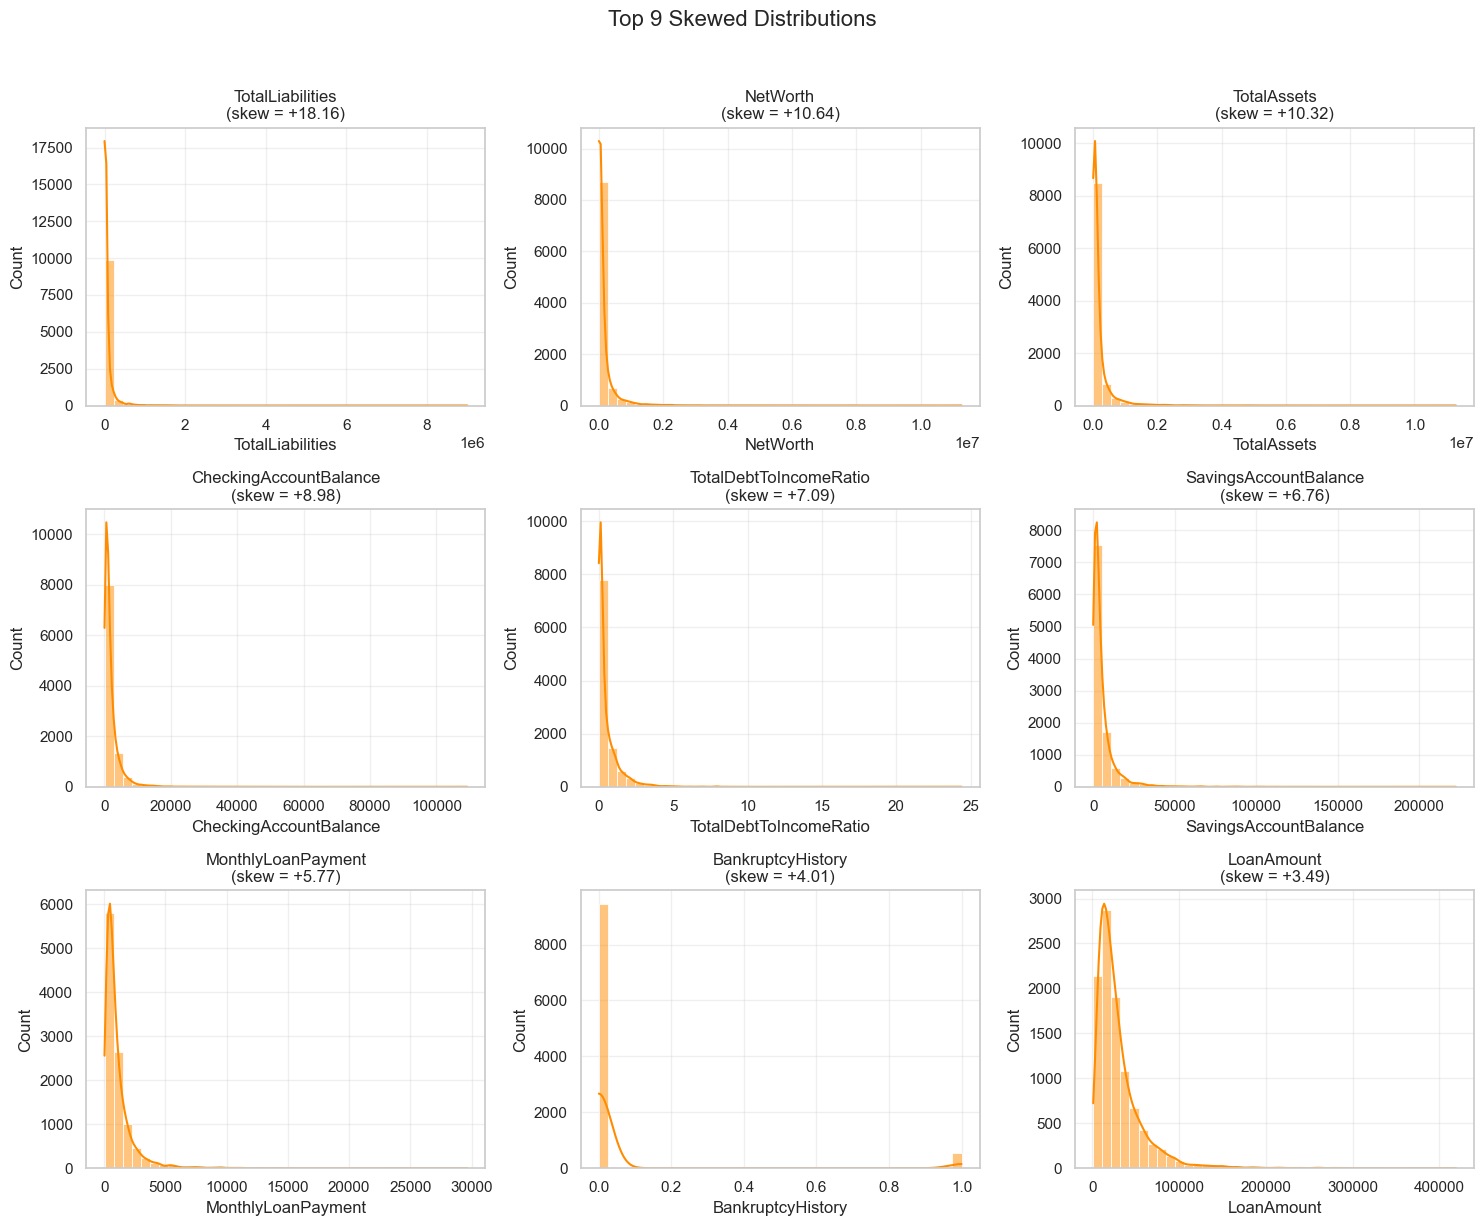

In [33]:
analyze_features(train, target_col="LoanApproved", max_scatters=9, max_hists=9, max_corr_features=30)


In [34]:
from src.metrics import accuracy, precision, recall, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score as sklearn_f1

# тестовые данные
y_true = np.array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1])
y_pred = np.array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1])

print("=== Сравнение метрик ===")
print(f"Accuracy:  custom={accuracy(y_true, y_pred):.6f}, sklearn={accuracy_score(y_true, y_pred):.6f}")
print(f"Precision: custom={precision(y_true, y_pred):.6f}, sklearn={precision_score(y_true, y_pred):.6f}")
print(f"Recall:    custom={recall(y_true, y_pred):.6f}, sklearn={recall_score(y_true, y_pred):.6f}")
print(f"F1-score:  custom={f1_score(y_true, y_pred):.6f}, sklearn={sklearn_f1(y_true, y_pred):.6f}")


=== Сравнение метрик ===
Accuracy:  custom=0.800000, sklearn=0.800000
Precision: custom=0.857143, sklearn=0.857143
Recall:    custom=0.857143, sklearn=0.857143
F1-score:  custom=0.857143, sklearn=0.857143


In [35]:
# препроцессинг
from sklearn.model_selection import train_test_split

# перезагрузим
train = pd.read_csv("data/train_c.csv")
test = pd.read_csv("data/test_c.csv")

# удалим строки с пропусками в target
train_clean = train.dropna(subset=['LoanApproved']).copy()

# разделим на X и y
X = train_clean.drop(['LoanApproved', 'ApplicationDate'], axis=1)
y = train_clean['LoanApproved'].values
test = test.drop(['ApplicationDate'], axis=1)

# заполним пропуски
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=['object']).columns

X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])

test[num_cols] = test[num_cols].fillna(X[num_cols].median())
test[cat_cols] = test[cat_cols].fillna(X[cat_cols].mode().iloc[0])

# one-hot encoding
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)

# выравнивание
test = test.reindex(columns=X.columns, fill_value=0)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}")
print(f"Test: {test.shape}")


X_train: (8389, 44), X_val: (2098, 44)
y_train: (8389,), y_val: (2098,)
Test: (5000, 44)


In [36]:
# сравнение bagging
from src.ensemble import MyBaggingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb


models = {
    'Custom Bagging': MyBaggingClassifier(n_estimators=10, random_state=42),
    'Sklearn Bagging': BaggingClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=10, max_depth=10, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=10, max_depth=10, random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(n_estimators=10, max_depth=10, random_state=42, verbose=-1)
}

print("Bagging Comparison\n")
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1] if name != 'Custom Bagging' else model.predict_proba(X_val)
    y_pred = (y_proba >= 0.5).astype(int)
    
    results[name] = {
        'ROC-AUC': roc_auc_score(y_val, y_proba),
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1': f1_score(y_val, y_pred)
    }

df_results = pd.DataFrame(results).T
print(df_results.to_string())

# разница с моей реализацией
print("Разница с Custom Bagging (ROC-AUC):")
custom_auc = results['Custom Bagging']['ROC-AUC']
for name in results:
    if name != 'Custom Bagging':
        diff = results[name]['ROC-AUC'] - custom_auc
        print(f"  {name}: {diff:+.6f}")

best_model = df_results['ROC-AUC'].idxmax()
print(f"\nЛучшая модель: {best_model} (ROC-AUC = {df_results.loc[best_model, 'ROC-AUC']:.6f})")


Bagging Comparison

                    ROC-AUC  Accuracy  Precision    Recall        F1
Custom Bagging     0.970919  0.918494   0.910828  0.932030  0.921307
Sklearn Bagging    0.973439  0.915157   0.915584  0.918994  0.917286
Random Forest      0.974894  0.919924   0.921788  0.921788  0.921788
Gradient Boosting  0.967144  0.913727   0.912281  0.919926  0.916087
XGBoost            0.976899  0.924690   0.926443  0.926443  0.926443
LightGBM           0.973064  0.912297   0.905282  0.925512  0.915285
Разница с Custom Bagging (ROC-AUC):
  Sklearn Bagging: +0.002520
  Random Forest: +0.003975
  Gradient Boosting: -0.003775
  XGBoost: +0.005980
  LightGBM: +0.002145

Лучшая модель: XGBoost (ROC-AUC = 0.976899)


In [37]:
# сравнение GradientBoosting
from src.ensemble import MyGradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score


models = {
    'Custom GB': MyGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'Sklearn GB': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbose=0)
}

print("GradientBoosting Comparison\n")
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1] if name != 'Custom GB' else model.predict_proba(X_val)
    y_pred = (y_proba >= 0.5).astype(int)
    
    results[name] = {
        'ROC-AUC': roc_auc_score(y_val, y_proba),
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1': f1_score(y_val, y_pred)
    }

df_results = pd.DataFrame(results).T
print(df_results.to_string())

# Разница с моей реализацией
print("Разница с Custom GB (ROC-AUC):")
custom_auc = results['Custom GB']['ROC-AUC']
for name in results:
    if name != 'Custom GB':
        diff = results[name]['ROC-AUC'] - custom_auc
        print(f"  {name}: {diff:+.6f}")

best_model = df_results['ROC-AUC'].idxmax()
print(f"\nЛучшая модель без подбора гиперпараметров: {best_model} (ROC-AUC = {df_results.loc[best_model, 'ROC-AUC']:.6f})")


GradientBoosting Comparison

             ROC-AUC  Accuracy  Precision    Recall        F1
Custom GB   0.981088  0.924214   0.924004  0.928305  0.926150
Sklearn GB  0.981096  0.924214   0.924004  0.928305  0.926150
LightGBM    0.980877  0.923737   0.923148  0.928305  0.925720
XGBoost     0.980735  0.923260   0.923863  0.926443  0.925151
CatBoost    0.980182  0.922307   0.924511  0.923650  0.924080
Разница с Custom GB (ROC-AUC):
  Sklearn GB: +0.000008
  LightGBM: -0.000211
  XGBoost: -0.000353
  CatBoost: -0.000906

Лучшая модель без подбора гиперпараметров: Sklearn GB (ROC-AUC = 0.981096)


In [38]:
# подбор гиперпараметров через optuna для XGBoost.
# по метрикам лучшая sklearn,
# но это без подбора гипермараметров. 
# для sklearn они подбираются очень долго.

import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score


optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'eval_metric': 'logloss',
        'verbosity': 0
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_proba)

print("Optuna Hyperparameter Tuning (XGBoost)")
study = optuna.create_study(direction='maximize', study_name='xgboost_optimization')
study.optimize(
    objective, 
    n_trials=100, 
    show_progress_bar=False,
)

print(f"\nЛучшие параметры: {study.best_params}")
print(f"Лучший ROC-AUC: {study.best_value:.6f}")

# обучаем финальную модель
best_params = study.best_params
best_params['random_state'] = 42
best_params['eval_metric'] = 'logloss'
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

print(f"\nФинальная модель обучена с параметрами: {best_params}")


Optuna Hyperparameter Tuning (XGBoost)

Лучшие параметры: {'n_estimators': 470, 'max_depth': 11, 'learning_rate': 0.04935434382404615, 'subsample': 0.6146793132955477, 'colsample_bytree': 0.6732815516693769, 'colsample_bylevel': 0.8447379329364642, 'min_child_weight': 2, 'gamma': 0.24385840152218846, 'reg_alpha': 0.6667993467931269, 'reg_lambda': 0.03228188121759584}
Лучший ROC-AUC: 0.983485

Финальная модель обучена с параметрами: {'n_estimators': 470, 'max_depth': 11, 'learning_rate': 0.04935434382404615, 'subsample': 0.6146793132955477, 'colsample_bytree': 0.6732815516693769, 'colsample_bylevel': 0.8447379329364642, 'min_child_weight': 2, 'gamma': 0.24385840152218846, 'reg_alpha': 0.6667993467931269, 'reg_lambda': 0.03228188121759584, 'random_state': 42, 'eval_metric': 'logloss'}


In [39]:
# финальные предсказания и submission
print(final_model)
y_val_proba = final_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba >= 0.5).astype(int)

print("Финальные метрики на валидации")
print(f"ROC-AUC:   {roc_auc_score(y_val, y_val_proba):.6f}")
print(f"Accuracy:  {accuracy_score(y_val, y_val_pred):.6f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.6f}")
print(f"Recall:    {recall_score(y_val, y_val_pred):.6f}")
print(f"F1-score:  {f1_score(y_val, y_val_pred):.6f}")

# предсказания на test
y_test_proba = final_model.predict_proba(test)[:, 1]

submission = pd.DataFrame({
    'ID': range(len(y_test_proba)),
    'LoanApproved': y_test_proba
})
submission.to_csv('submission.csv', index=False)
print(f"\nSubmission файл сохранен: submission.csv")
print(f"Размер: {submission.shape}")
print(submission.head())


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8447379329364642, colsample_bynode=None,
              colsample_bytree=0.6732815516693769, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0.24385840152218846, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04935434382404615,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=470, n_jobs=None,
              num_parallel_tree=None, ...)
Финальные метрики на валидации
ROC-AUC:   0.983485
Accuracy:  0.928027
Precision: 0.929302
Recall:    0.930168
F1-score:  0.929735

Submission файл сохранен: submission